## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Undestort Image
---
`cv2.findfindChessboardCorners` and `cv2.calibrateCamera` are used to get calibration matrix. 

This matrix makes distorted images to be undistorted.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from utils.CameraCalibration import CameraCalibration # import Calibaration

In [3]:
# Make a list of calibration images
chkboard_images = glob.glob('./camera_cal/calibration*.jpg')

# 
calibration = CameraCalibration(chkboard_images)

In [4]:
calibration.mtx, calibration.dist

(array([[  1.15777829e+03,   0.00000000e+00,   6.67113866e+02],
        [  0.00000000e+00,   1.15282230e+03,   3.86124658e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688572, -0.02372824, -0.00109832,  0.00035104, -0.00260433]]))

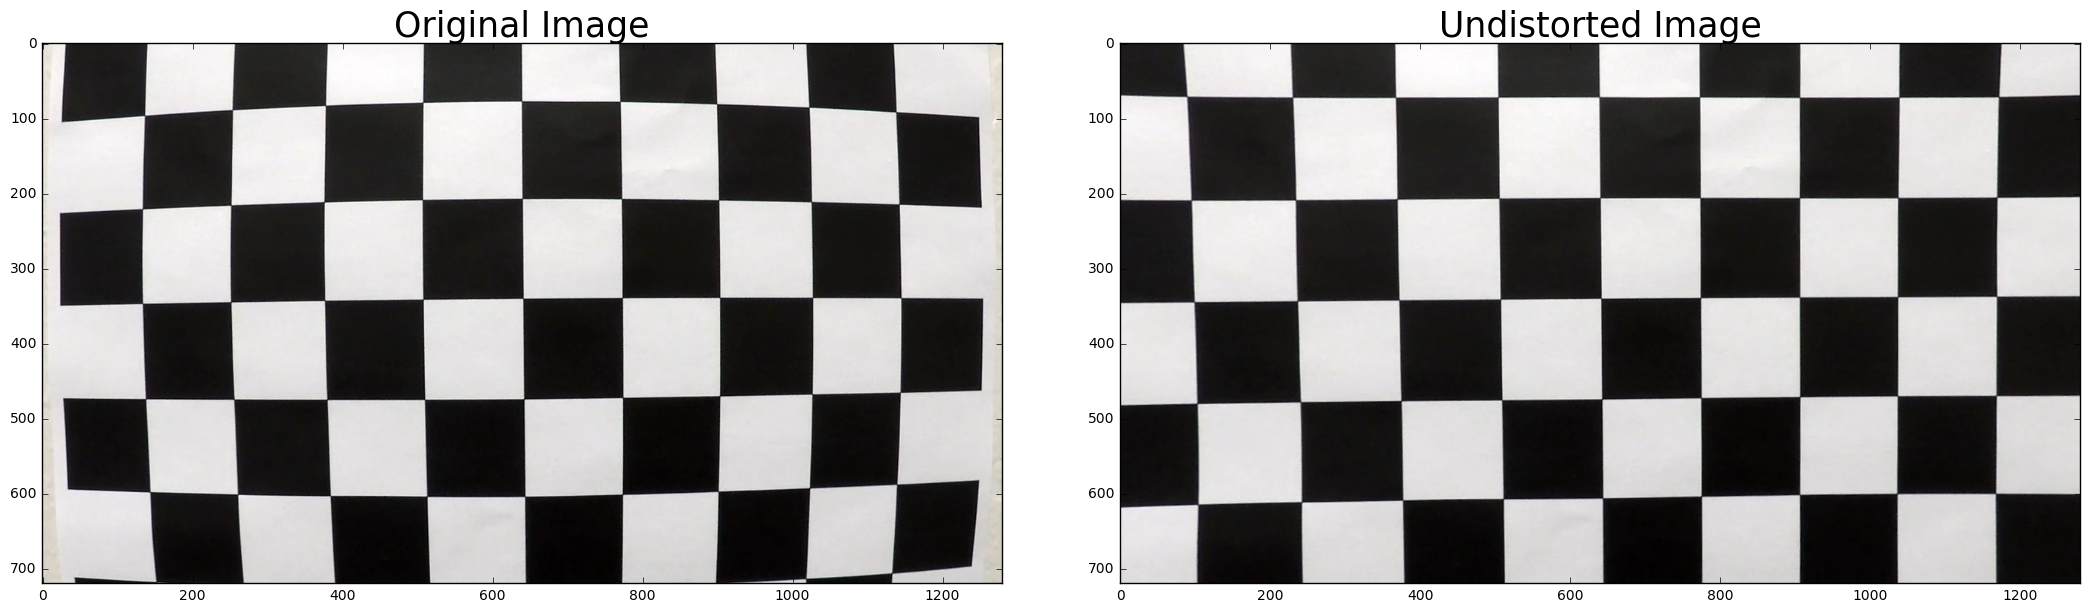

In [5]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Image Thresholding
---

Color thresholding: Thresholding works well in HSL color space. 
- S > 150 for **yellow** lane line
- L > 180 for **white** lane line

binrary images of yellow and white lane line are combined into `binary_color`

In [6]:
from utils.Thresholding import ImageColorThres

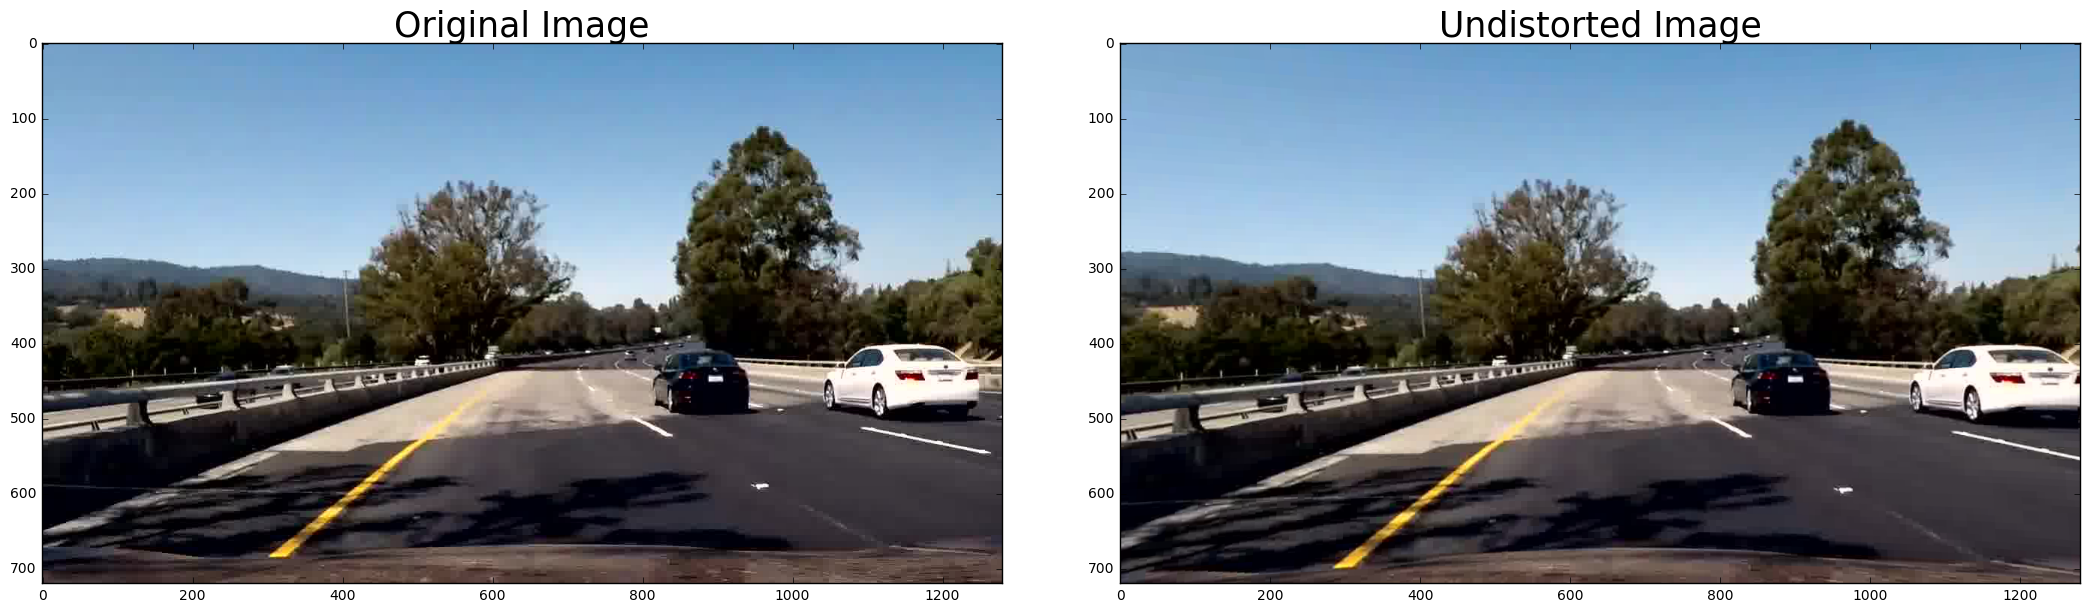

In [7]:
# load road image
img = cv2.imread('./hardpart_image/img_073.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB

undimg = calibration.undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
imshape = undimg.shape # image size
print("image shape: ", imshape)

roi_vertices = np.array([[(0,imshape[0]), 
                        (imshape[1]*7/15, imshape[0]*3/5), 
                        (imshape[1]*8/15, imshape[0]*3/5), 
                        (imshape[1],imshape[0])]], 
                         dtype=np.int32) # vertices of roi

colorthres = ImageColorThres(img, roi_vertices)

image shape:  (720, 1280, 3)


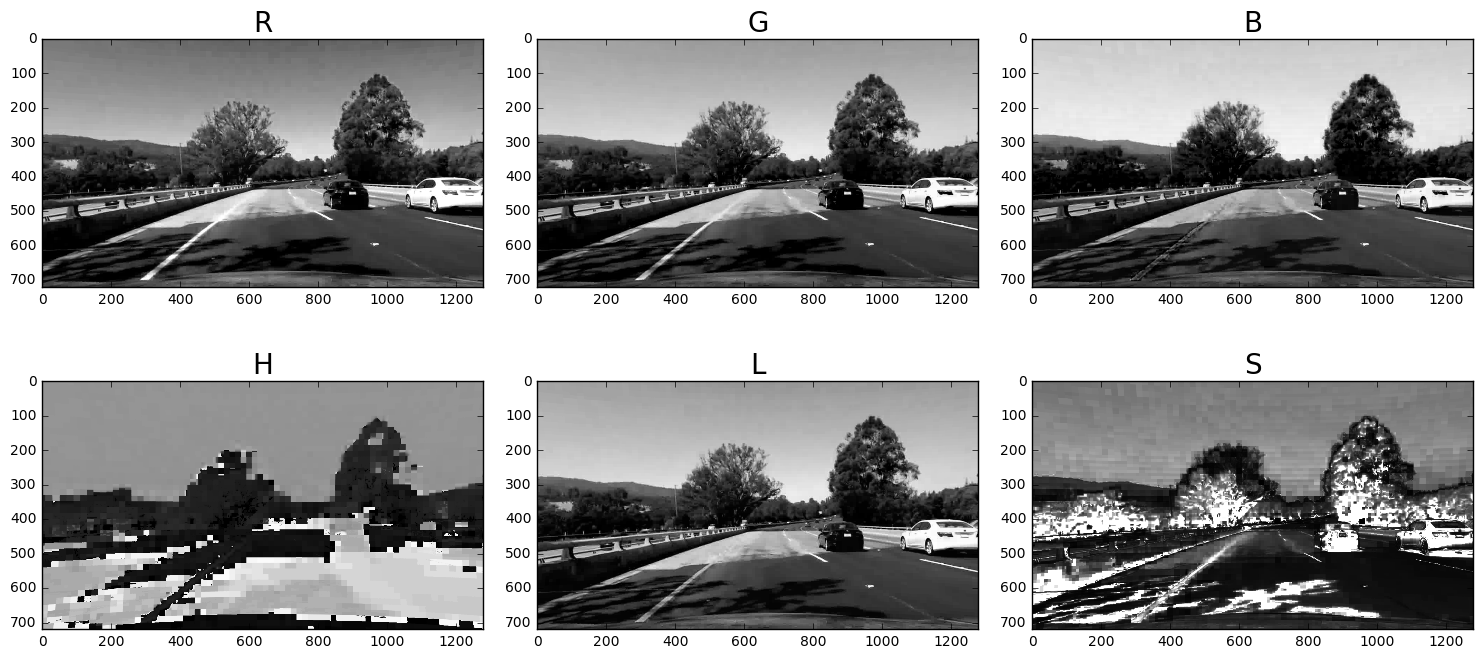

In [9]:
f, axes = plt.subplots(2, 3, figsize=(15, 7))
f.tight_layout()
axes[0,0].imshow(undimg[:,:,0], cmap='gray')
axes[0,0].set_title('R', fontsize=20)

axes[0,1].imshow(undimg[:,:,1], cmap='gray')
axes[0,1].set_title('G', fontsize=20)

axes[0,2].imshow(undimg[:,:,2], cmap='gray')
axes[0,2].set_title('B', fontsize=20)

hls_ = cv2.cvtColor(undimg, cv2.COLOR_RGB2HLS)

axes[1,0].imshow(hls_[:,:,0], cmap='gray')
axes[1,0].set_title('H', fontsize=20)

axes[1,1].imshow(hls_[:,:,1], cmap='gray')
axes[1,1].set_title('L', fontsize=20)

axes[1,2].imshow(hls_[:,:,2], cmap='gray')
axes[1,2].set_title('S', fontsize=20)

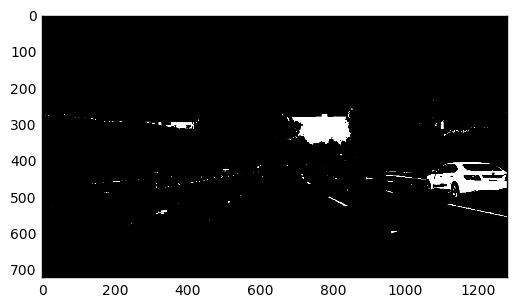

0.0 1.0


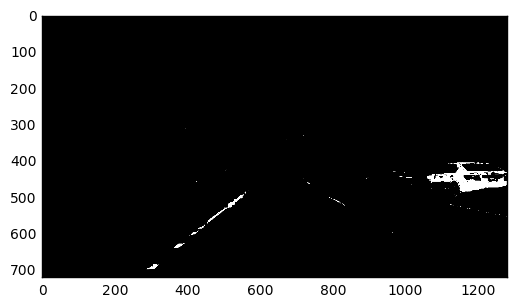

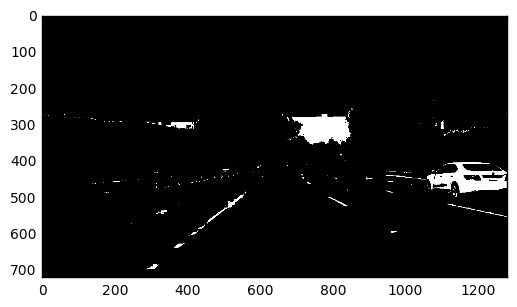

In [26]:
R_ = undimg[:,:,0]
G_ = undimg[:,:,1]
B_ = undimg[:,:,2]
S_ = hls_[:,:,2]
L_ = hls_[:,:,1]

whiteline = np.zeros_like(R_)
comw = R_/255 * G_/255 * B_/255
whiteline[comw>0.63] = 1
plt.imshow(whiteline, cmap='gray')
plt.show()

com = R_/255 * S_/255
yellowline = np.zeros_like(R_)
yellowline[com > 0.8] = 1

plt.imshow(yellowline, cmap='gray')
print(np.amin(com), np.amax(com))
plt.show()

binary_color = np.zeros_like(yellowline)
binary_color = np.maximum(yellowline, whiteline) # combine white and yellow using maximum

plt.imshow(binary_color, cmap='gray')

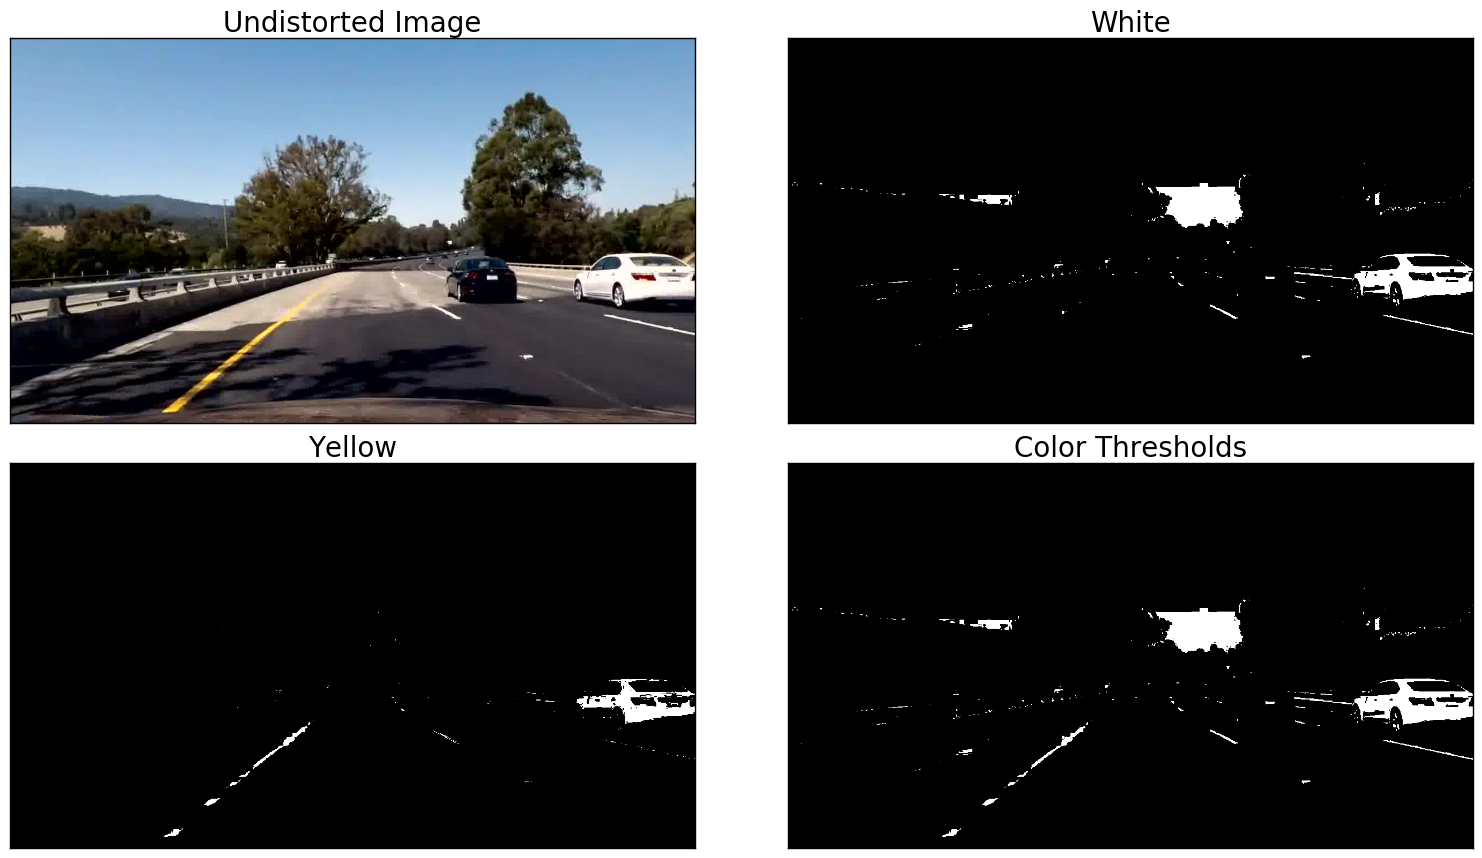

In [27]:
f, axes = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()
axes[0,0].imshow(undimg)
axes[0,0].set_title('Undistorted Image', fontsize=20)

axes[1,0].imshow(yellowline, cmap='gray')
axes[1,0].set_title('Yellow', fontsize=20)

axes[0,1].imshow(whiteline, cmap='gray')
axes[0,1].set_title('White', fontsize=20)

axes[1,1].imshow(binary_color, cmap='gray')
axes[1,1].set_title('Color Thresholds', fontsize=20)

for i in range(2):
    for j in range(2):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient Filter
---
Gradient Thresholding
- gradient in x-direction: threshold = (50, 200)
- gradient in y-direction: same as above.

two thresholded images are combined into `color_grad`.

In [12]:
import utils.GradientThresholding as gradThres

In [13]:
redimg = undimg[:,:,0]
redimg_blur = gradThres.gaussian_blur(redimg, 3)

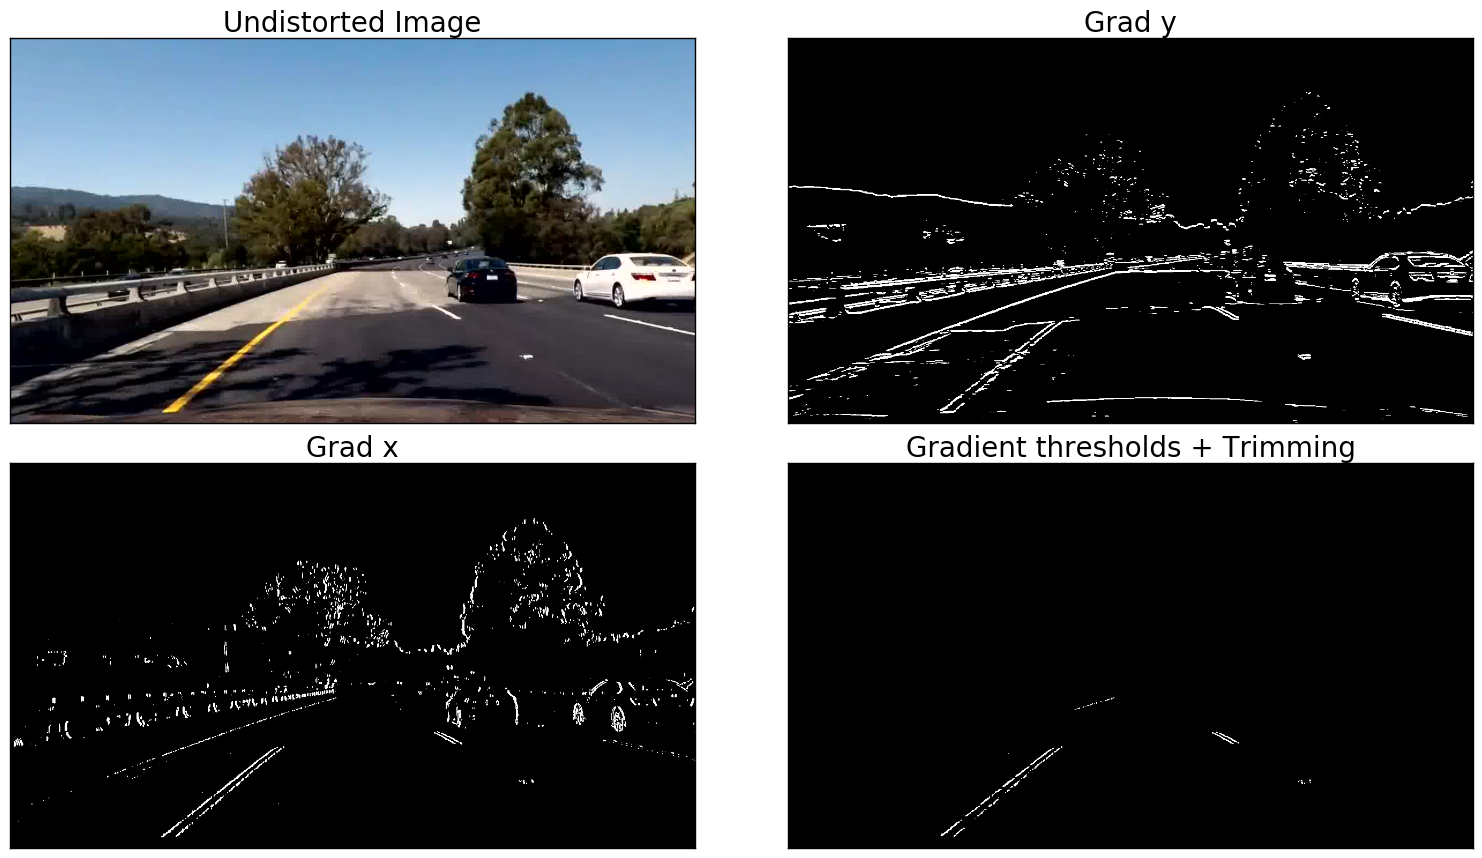

In [14]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = gradThres.abs_sobel_thresh(redimg_blur, orient='x', sobel_kernel=ksize, thresh=(50, 200))
grady = gradThres.abs_sobel_thresh(redimg_blur, orient='y', sobel_kernel=ksize, thresh=(50, 200))

# Combine gradient and trim roi
combined = np.zeros_like(gradx)
combined[((gradx == 1) & (grady == 1))] = 1
binary_grad = gradThres.region_of_interest(combined, roi_vertices)

# plot result
f, axes = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()
axes[0,0].imshow(undimg)
axes[0,0].set_title('Undistorted Image', fontsize=20)

axes[1,0].imshow(gradx, cmap='gray')
axes[1,0].set_title('Grad x', fontsize=20)

axes[0,1].imshow(grady, cmap='gray')
axes[0,1].set_title('Grad y', fontsize=20)

axes[1,1].imshow(binary_grad, cmap='gray')
axes[1,1].set_title('Gradient thresholds + Trimming', fontsize=20)

for i in range(2):
    for j in range(2):
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combine color thresholds and gradient thresholds
---
Almost done!

Now we have to combine color and gradient thresholds images. 

the result image assigns in `finimg`

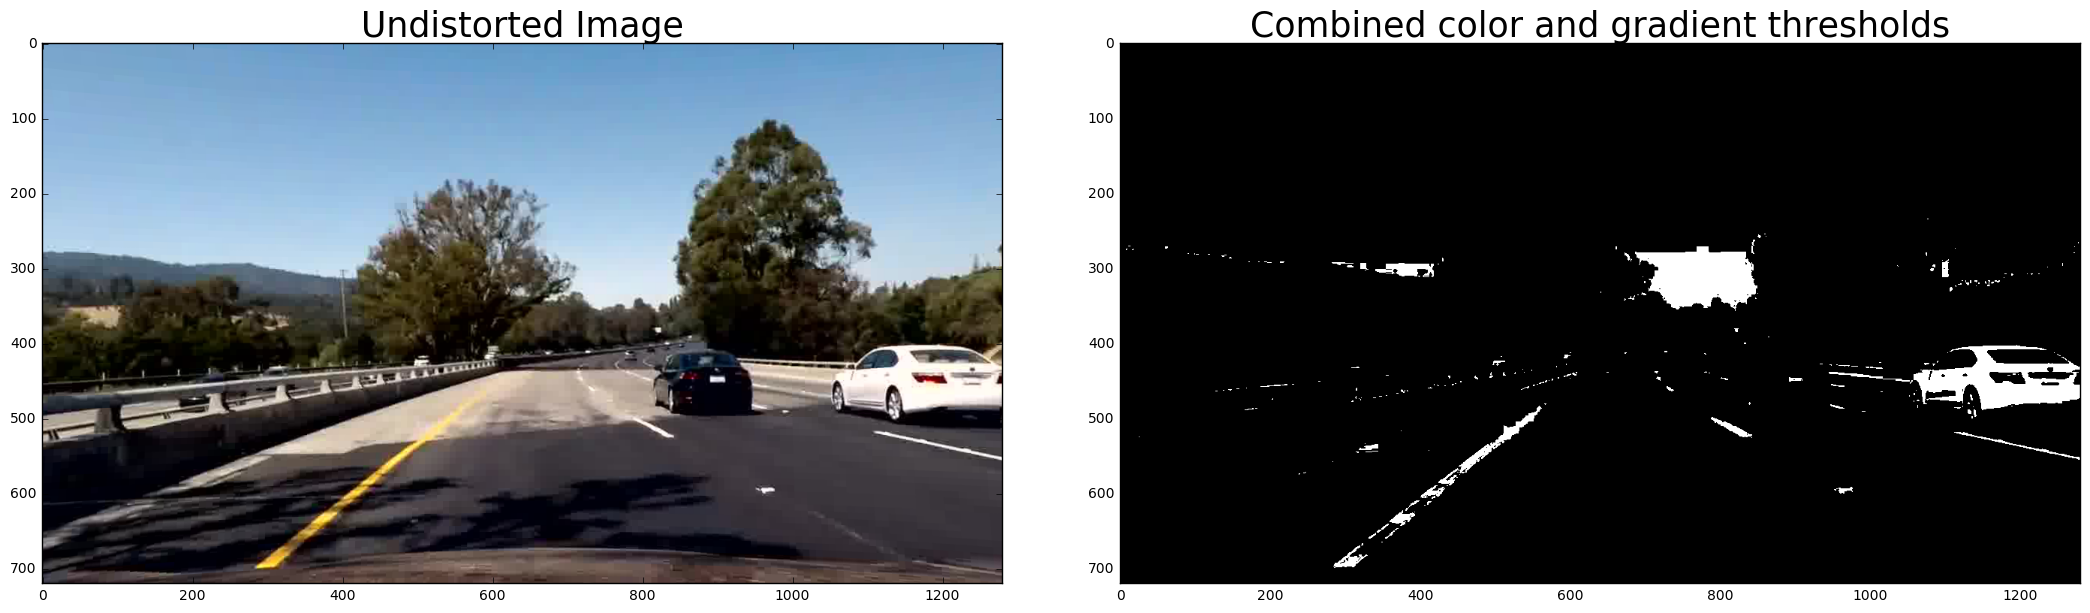

In [15]:
finimg = np.zeros_like(redimg)
finimg[(binary_grad == 1) | (binary_color ==1)] = 1

# plot result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(undimg)
ax1.set_title('Undistorted Image', fontsize=25)
plt.imshow(finimg, cmap='gray')
ax2.set_title('Combined color and gradient thresholds', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform
---
Compute the perspective transform, M, given source and destination points:

```
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
```

Using this `M`, Warp `finimg` into `binray_warped`.

In [16]:
from utils.PerspectiveTransform import PerspectiveTransform

In [17]:
perspective = PerspectiveTransform(finimg)

In [18]:
perspective.M, perspective.Minv

(array([[ -6.24454148e-01,  -1.50764192e+00,   1.03724891e+03],
        [ -7.66053887e-15,  -1.96506550e+00,   9.03930131e+02],
        [ -9.86623977e-18,  -2.37445415e-03,   1.00000000e+00]]),
 array([[  1.47727273e-01,  -7.78472222e-01,   5.50454545e+02],
        [  2.22044605e-16,  -5.08888889e-01,   4.60000000e+02],
        [ -8.67361738e-19,  -1.20833333e-03,   1.00000000e+00]]))

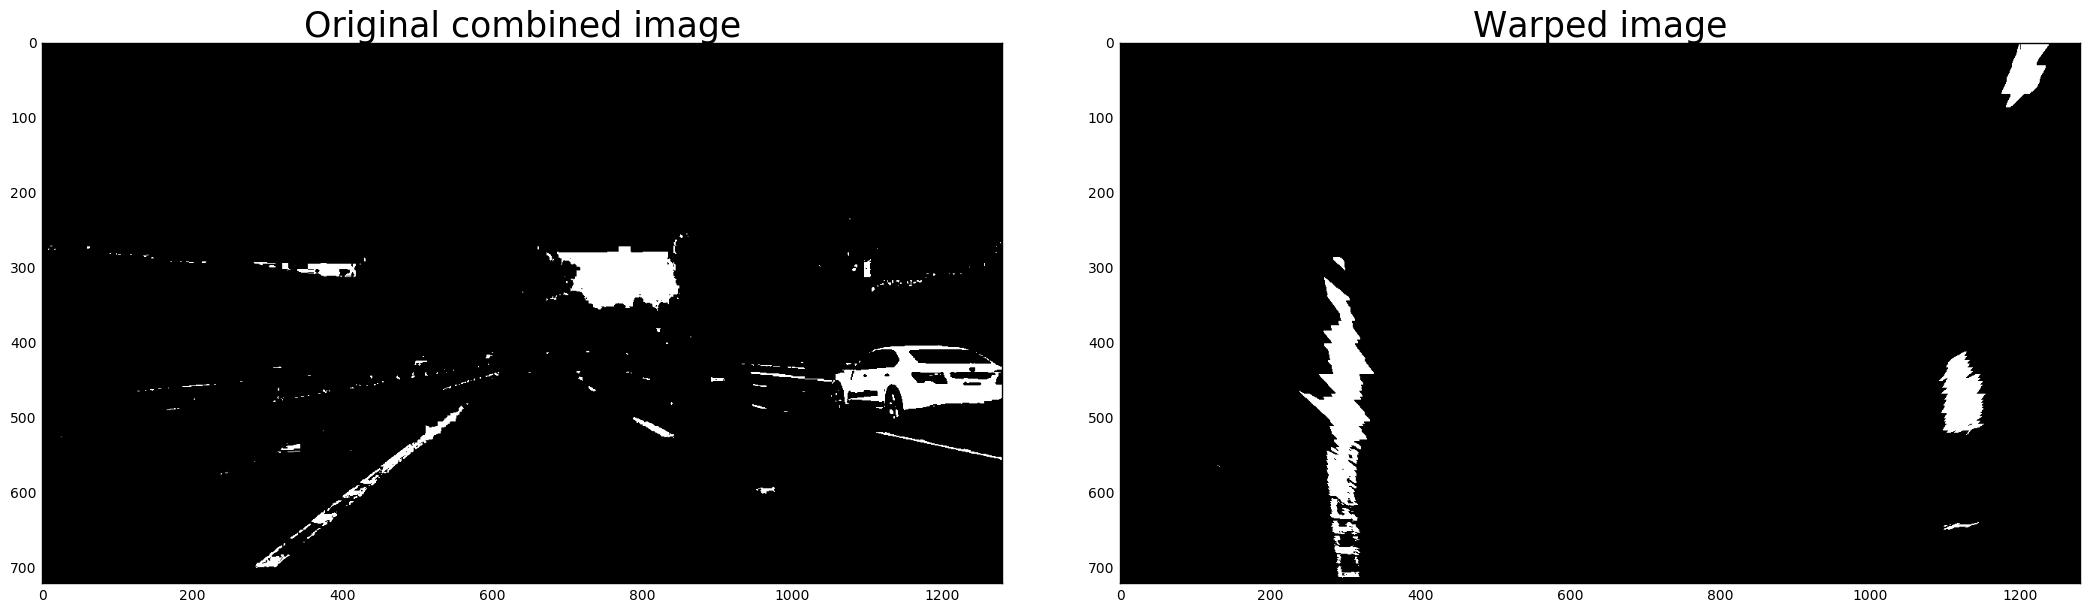

In [19]:
binary_warped = perspective.warp_image(finimg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(finimg, cmap='gray')
ax1.set_title('Original combined image', fontsize=25)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Lane Lines
---
From warped (bird eye's view) image, Left/Right polynomial function and radius of curvature are calculated.

The steps for finding lane lines are as follow:
1. Make **histogram** of bottom half of image.
2. Find the **peak** of the left and right havles of the histogram.
    They are starting point for te left and right lines.
3. Do **window search** from 0 to image height.
4. **Fit** the result points get from window search into **polynomial function.**
    Using conversions in x and y from pixels space to meters, calcualte the radius of curvatures and cross track error
5. Draw the result on warped image.
6. **Warp** the result image using inverse perspective transform `Minv`.

*In video processing, you do not have to search all the intervals, the algorithm **remembers the line position in the previous frame** and search only near that line position. With this method, the calculation time can be greatly improved.*

In [20]:
from utils.FindLaneLine import *

In [21]:
out_img, window_img, result, left_fit, right_fit, left_curverad, right_curverad, cte = window_search(binary_warped, nwindows=10)
print('radius of curvature: %.3f m, %.3fm' % (left_curverad, right_curverad))
print('cte: %.3f m' % (cte))

radius of curvature: 2488.790 m, 482.638m
cte: 0.387 m


(720, 0)

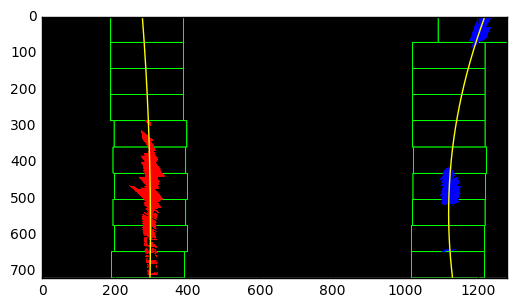

In [22]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

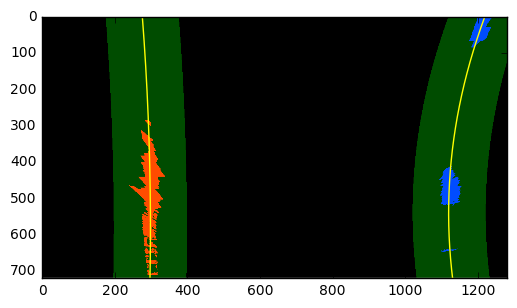

In [23]:
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the **next frame** of video you don't need to do a blind search again, but instead you can just **search in a margin** around the **previous line position** like this:

In [24]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:


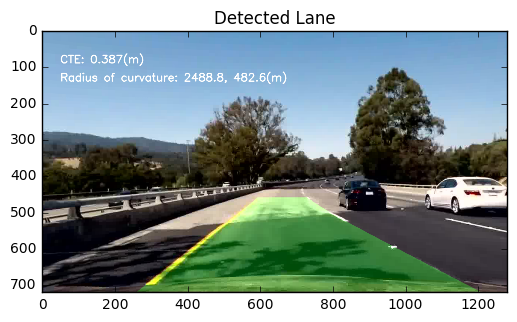

In [25]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = perspective.unwarp_image(color_warp)

# Combine the result with the original image
result = cv2.addWeighted(undimg, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'CTE: %.3f(m)' %(cte) ,(50,90), font, 1,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result, 'Radius of curvature: %.1f, %.1f(m)' %(left_curverad, right_curverad) ,(50,140), font, 1,(255,255,255),2,cv2.LINE_AA)
plt.imshow(result)
plt.title('Detected Lane')